In [230]:
def get_object_detection_boxes(results):
    X = []

    for result in results:
        boxes = result.boxes  # box 객체

        if boxes is None or boxes.xyxy is None:
            continue

        for i in range(boxes.xyxy.shape[0]):
            xyxy = boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = xyxy
            X.append([int(x1), int(y1), int(x2), int(y2)])

    return np.array(X)

In [259]:
def plot_g(X,labels):
    # plt.figure(figsize=(6, 5))

    unique_labels = np.unique(labels)
    for k in unique_labels:
        mask = (labels == k)
        n = int(mask.sum())
        if k == -1:
            # 노이즈
            plt.scatter(X[mask, 0], X[mask, 1],
                        marker='x', s=30, linewidths=1,
                        label=f'Noise (-1)  n={n}', alpha=0.9)
        else:
            # 각 클러스터별로 따로 그려야 legend에 항목이 생김
            plt.scatter(X[mask, 0], X[mask, 1],
                        s=20, label=f'Cluster {k}  count={n}', alpha=0.5)

    plt.xlabel('width')
    plt.ylabel('height')
    plt.title('Clusters')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show() 
    

In [ ]:
import cv2, ctypes
from processing import get_object_detection_boxes , cluster_boxes
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, HDBSCAN    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from ultralytics import YOLO
img = r"E:\다운로드\KakaoTalk_20250814_141911336_02.jpg"
imgs = cv2.imread(img)


model = YOLO("weights.pt")



def cluster_boxes(boxes, eps=0.34990236345839165, min_samples=5):
    """
    boxes: List of bounding boxes [x1, y1, x2, y2]
    ocr_texts: OCR 결과 텍스트 리스트
    eps: DBSCAN의 거리 임계값 (같은 행으로 간주할 y축 거리)
    min_samples: 최소 샘플 수 (1로 하면 모든 점 포함 가능)
    
    return: 각 행에 대한 결과 
    """
    if boxes is None or len(boxes) == 0: # 예외처리
        return np.array([]).reshape(0, 1)    
    
    # 박스 하단 y좌표 계산
    X =boxes[:,2:4]
    X_scaler = StandardScaler().fit_transform(X)
    # print(y_centers)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaler)
    # clustering = HDBSCAN(min_cluster_size=2, store_centers = 'centroid' ).fit(X_scaler)
    # clustering = Kmeans
    labels = clustering.labels_  # 각 박스가 속한 행 번호
    # clustering.

    print("클러스터 라벨들:", sorted(set(labels)))
    plot_g(X,labels)    
    return labels.reshape(-1,1)

In [232]:
results = model(img)[0]


image 1/1 E:\\KakaoTalk_20250814_141911336_02.jpg: 640x480 94 book_labels, 108.7ms
Speed: 2.5ms preprocess, 108.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


In [233]:
boxes = get_object_detection_boxes(results)

클러스터 라벨들: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]


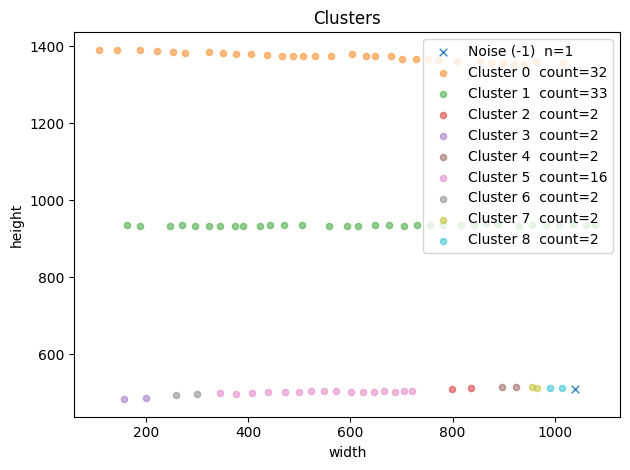

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [ 3],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 2],
       [ 4],
       [ 0],
       [ 0],
       [ 1],
       [ 5],
       [ 1],
       [ 0],
       [ 5],
       [ 5],
       [ 6],
       [ 0],
       [ 1],
       [ 5],
       [ 5],
       [ 5],
       [ 1],
       [ 6],
       [ 0],
       [ 0],
       [ 5],
       [ 5],
       [ 5],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 0],
       [ 8],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 5],
       [ 1],
       [ 1],
       [ 5],
       [ 7],
       [ 1],
       [ 0],
       [ 0],
       [ 5],
       [ 1],
       [ 1],
       [ 3],
       [ 0],

In [266]:
cluster_boxes(boxes)

In [235]:
cluster_boxes

<function __main__.cluster_boxes(boxes, eps=0.34990236345839165, min_samples=5)>

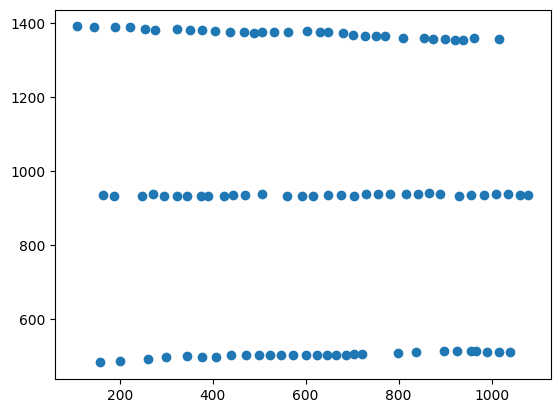

In [236]:
import matplotlib.pyplot as plt

plt.scatter(boxes[:,2],boxes[:,3])

In [237]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def choose_k_and_label(X):  # X: (n,2) [x1,y1]
    Xz = MinMaxScaler().fit_transform(X)
    print(Xz)
    # k=1 inertia
    km1 = KMeans(n_clusters=1, n_init=20, random_state=42).fit(Xz)
    inertia1 = km1.inertia_

    results = {}
    for k in (2, 3):
        km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(Xz)
        labels = km.labels_
        sil = silhouette_score(Xz, labels)
        results[k] = {"model": km, "labels": labels, "sil": sil, "inertia": km.inertia_}

    # 단일 클러스터 여부 점검
    inertia_drop = (inertia1 - results[2]["inertia"]) / max(inertia1, 1e-9)
    if (inertia_drop < 0.10) and (results[2]["sil"] < 0.20) and (results[3]["sil"] < 0.20):
        return 1, km1.labels_

    # k=2 vs k=3 선택 (동점이면 inertia 감소 큰 쪽)
    k_best = max((2,3), key=lambda k: (results[k]["sil"], (inertia1 - results[k]["inertia"])))
    return k_best, results[k_best]["labels"]

# 사용 예:
X = np.concatenate([boxes[:,2].reshape(-1,1),boxes[:,3].reshape(-1,1)],axis= 1)
print(X.shape)
k, labels = choose_k_and_label(X)
print(k)
 

(94, 2)
[[   0.082474      0.9989]
 [   0.036082      0.9989]
 [    0.25052     0.99009]
 [    0.93608     0.96256]
 [    0.51031     0.98789]
 [    0.76804     0.96696]
 [          0           1]
 [    0.58866     0.98128]
 [    0.46392      0.4967]
 [    0.40928         0.5]
 [   0.094845    0.003304]
 [    0.36907     0.98238]
 [    0.81443     0.96256]
 [    0.27629     0.98899]
 [    0.55567     0.98238]
 [    0.37216      0.4989]
 [     0.2433     0.49449]
 [    0.43608     0.98348]
 [    0.95567      0.5011]
 [    0.83711     0.96035]
 [    0.46804     0.98348]
 [     0.5567      0.4978]
 [    0.11753      0.9978]
 [    0.64021         0.5]
 [    0.52165      0.4967]
 [    0.75052    0.031938]
 [    0.81237    0.034141]
 [     0.1732     0.99009]
 [    0.30619     0.98678]
 [    0.49897      0.4967]
 [    0.45258    0.023128]
 [    0.19278      0.4967]
 [    0.33814     0.98458]
 [     0.4268    0.023128]
 [     0.2433    0.018722]
 [    0.19691    0.015419]
 [    0.61134     0.

In [238]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

def _kneedle_eps(dist_sorted):
    """시작-끝 직선과 각 점 사이 최대 거리 지점을 elbow로."""
    x = np.arange(len(dist_sorted))
    x1, y1 = 0, dist_sorted[0]
    x2, y2 = len(dist_sorted)-1, dist_sorted[-1]
    den = np.hypot(x2-x1, y2-y1) + 1e-12
    # 점-직선 거리
    d = np.abs((y2 - y1)*x - (x2 - x1)*dist_sorted + x2*y1 - y2*x1) / den
    idx = int(np.argmax(d))
    return float(dist_sorted[idx])

def _k_distance(Xz, k):
    nn = NearestNeighbors(n_neighbors=k).fit(Xz)
    dists, _ = nn.kneighbors(Xz)
    return np.sort(dists[:, -1])  # 각 점의 k번째 이웃 거리

def auto_dbscan(X, dims=2, min_samples_grid=None, noise_cap=0.5, random_state=42):
    """
    X: (n,d) 데이터
    dims: 차원(D) — 2D면 2
    min_samples_grid: 시도할 min_samples 목록(미지정 시 경험값 사용)
    noise_cap: 노이즈 비율 상한(이보다 크면 후보 탈락)
    반환: best_params, labels
    """
    Xz = StandardScaler().fit_transform(X)
    if min_samples_grid is None:
        # 2D 기준 5~15 권장, 차원 높으면 2D 경험칙
        base = max(dims + 1, 4)
        min_samples_grid = sorted(set([base, 2*dims, 5, 8, 10, 12, 15]))

    best = None
    best_labels = None

    for ms in min_samples_grid:
        kd = _k_distance(Xz, k=ms)
        eps = _kneedle_eps(kd)
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xz)

        # 품질 휴리스틱 계산
        mask = labels != -1
        n_noise = np.sum(~mask)
        noise_ratio = n_noise / len(labels)
        n_clusters = len(set(labels[mask]))  # 노이즈 제외
        if n_clusters == 0 or noise_ratio > noise_cap:
            continue

        # 실루엣(노이즈 제외) – 참고용
        try:
            sil = silhouette_score(Xz[mask], labels[mask]) if len(np.unique(labels[mask])) > 1 else -1
        except Exception:
            sil = -1

        score = (sil, -noise_ratio, -abs(n_clusters-3))  # 예: 실루엣↑, 노이즈↓, 클러스터 수는 3에 가깝게(원하면 바꾸세요)
        if (best is None) or (score > best["score"]):
            best = {"eps": eps, "min_samples": ms, "sil": sil,
                    "noise_ratio": noise_ratio, "n_clusters": n_clusters,
                    "score": score}
            best_labels = labels

    if best is None:
        # 보수적으로 min_samples를 크게, eps를 elbow로 재시도
        ms = max(min_samples_grid) + 5
        kd = _k_distance(StandardScaler().fit_transform(X), k=ms)
        eps = _kneedle_eps(kd)
        best = {"eps": eps, "min_samples": ms, "sil": -1, "noise_ratio": 1.0, "n_clusters": 0, "score": (-1,-1,-999)}
        best_labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(StandardScaler().fit_transform(X))

    return best, best_labels

# 사용 예시

best, labels = auto_dbscan(boxes, dims=2)
print(best)  # {'eps': ..., 'min_samples': ..., 'sil': ..., 'noise_ratio': ..., 'n_clusters': ...}


{'eps': 0.34990236345839165, 'min_samples': 4, 'sil': 0.37194986059346863, 'noise_ratio': 0.07446808510638298, 'n_clusters': 4, 'score': (0.37194986059346863, -0.07446808510638298, -1)}
